In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import openmc
import openmc.deplete
import pandas as pd
from os import listdir
from os.path import isfile, join
#OPENMC_CROSS_SECTIONS = '/Users/Julian/nndc_hdf5/cross_sections.xml'

In [2]:
#OpenMC simulation parameters
batches = 100
inactive = 8
particles = 5000

Defining materials:

In [3]:
#Fuel material settings:
fuel_material = openmc.Material(11, name='Thorium fuel')
fuel_material.set_density('g/cm3', 10.062)
fuel_material.add_element("Th", 0.9)
fuel_material.add_nuclide('Pu239', 0.092) #weaponsgrade ref:
fuel_material.add_nuclide('Pu240', 0.008) #https://www.world-nuclear.org/information-library/nuclear-fuel-cycle/fuel-recycling/plutonium.aspx
fuel_material.add_element("O", 2.0)
fuel_material.depletable = True


#Fuel material setting
uo2_2 = openmc.Material(material_id=21, name='2nd Discretization, UO2 fuel at 2.4% wt enrichment')
uo2_2.set_density('g/cm3', 10.29769)
uo2_2.add_element('U', 1., enrichment=2.45)
uo2_2.add_element('O', 2.)
uo2_2.depletable = True

# Fuel gap material setting
helium = openmc.Material(material_id=13, name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)


# Fuel cladding material setting
clad = openmc.Material(material_id=14, name='Zircaloy 4')
clad.set_density('g/cm3', 6.55)
clad.add_element('Sn', 0.014  , 'wo')
clad.add_element('Fe', 0.00165, 'wo')
clad.add_element('Cr', 0.001  , 'wo')
clad.add_element('Zr', 0.98335, 'wo')



# Moderator material setting
borated_water = openmc.Material(material_id=15, name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')


# Cold water
cold_water = openmc.Material(material_id=16, name='Cold borated water')
cold_water.set_density('atom/b-cm', 0.07416)
cold_water.add_nuclide("H1", 2.0)
cold_water.add_nuclide("O16", 1.0)
cold_water.add_nuclide("B10", 6.490e-4)
cold_water.add_nuclide("B11", 2.689e-3)
cold_water.add_s_alpha_beta('c_H_in_H2O')

# Hot water
hot_water = openmc.Material(material_id=17, name='Hot borated water')
hot_water.set_density('atom/b-cm', 0.06614)
hot_water.add_nuclide("H1", 2.0)
hot_water.add_nuclide("O16", 1.0)
hot_water.add_nuclide("B10", 6.490e-4)
hot_water.add_nuclide("B11", 2.689e-3)
hot_water.add_s_alpha_beta('c_H_in_H2O')

#Heavy water:
heavy_water = openmc.Material(material_id=5, name='Heavy water')
heavy_water.set_density('g/cm3', 1.10452)
heavy_water.add_nuclide('H2', 2.)
heavy_water.add_element('O', 1.)
heavy_water.add_s_alpha_beta('c_D_in_D2O')


#Plain water:
plain_water = openmc.Material(material_id=6, name="plain water")
plain_water.set_density('g/cm3',0.99701)
plain_water.add_nuclide('H1',2.0)
plain_water.add_element('O',1.0)
plain_water.add_s_alpha_beta('c_H_in_H2O')



# Reactor shielding material
shielding = openmc.Material(material_id=19, name='Bottom plate region')
shielding.set_density('g/cm3', 7.184)
shielding.add_nuclide("H1", 0.0011505, 'wo')
shielding.add_nuclide("O16", 0.0091296, 'wo')
shielding.add_nuclide("B10", 3.70915e-6, 'wo')
shielding.add_nuclide("B11", 1.68974e-5, 'wo')
shielding.add_nuclide("Fe54", 0.03855611055, 'wo')
shielding.add_nuclide("Fe56", 0.627585036425, 'wo')
shielding.add_nuclide("Fe57", 0.014750478, 'wo')
shielding.add_nuclide("Fe58", 0.002000875025, 'wo')
shielding.add_nuclide("Ni58", 0.059855207342, 'wo')
shielding.add_nuclide("Mn55", 0.0197940, 'wo')
shielding.add_nuclide("Cr52", 0.157390026871, 'wo')
shielding.add_s_alpha_beta('c_H_in_H2O')

# Reactor pressure vessel material
steel = openmc.Material(material_id=20, name='Reactor pressure vessel steel')
steel.set_density('g/cm3', 7.9)
steel.add_nuclide("Fe54", 0.05437098, 'wo')
steel.add_nuclide("Fe56", 0.88500663, 'wo')
steel.add_nuclide("Fe57", 0.0208008, 'wo')
steel.add_nuclide("Fe58", 0.00282159, 'wo')
steel.add_nuclide("Ni58", 0.0067198, 'wo')
steel.add_nuclide("Ni60", 0.0026776, 'wo')
steel.add_nuclide("Mn55", 0.01, 'wo')
steel.add_nuclide("Cr52", 0.002092475, 'wo')
steel.add_nuclide("C0", 0.0025, 'wo')
steel.add_nuclide("Cu63", 0.0013696, 'wo')



#Unborated water:
norm_water = openmc.Material(material_id=22,name='test borated water')
norm_water.set_density('g/cm3', 0.740582)
norm_water.add_element('H', 2.0)
norm_water.add_element('O', 1.0)
norm_water.add_element('B', 25633.0 * 1e-6)
norm_water.add_s_alpha_beta('c_H_in_H2O')

Adding materials and exporting to .xml-file:

In [4]:
materials_thoriumreactor = openmc.Materials([fuel_material, uo2_2, helium,
                                            clad, borated_water,
                                            cold_water, hot_water,
                                            shielding, steel,
                                            heavy_water,norm_water,plain_water])

materials_thoriumreactor.cross_sections = '/Users/Julian/nndc_hdf5/cross_sections.xml'

materials_thoriumreactor.export_to_xml()

Creating the geometry:

In [5]:
#Creating the surfaces for the fuel elements
fuel_surf = openmc.ZCylinder(r=0.38218,surface_id=1) #Surface fuel pellets
fuel_surf_gap = openmc.ZCylinder(r=0.395,surface_id=2) #Surface fuel gap
fuel_surf_clad_ir = openmc.ZCylinder(r=0.41005,surface_id=3) #Surface fuel cladding inner radius
fuel_surf_clad_or = openmc.ZCylinder(r=0.46720,surface_id=4) #Surface fuel cladding outer radius


#Creating surfaces for tank and shielding
core_surf_tank_inner = openmc.ZCylinder(r=77.0,surface_id=5) #Inner surface reactor tank
core_surf_tank_outer = openmc.ZCylinder(r=80.0,surface_id=6) #Outer surface reactor tank
core_surf_vac = openmc.ZCylinder(r=90.0,surface_id=7, boundary_type='vacuum')

core_surf_shield_low = openmc.ZPlane(z0=-90.0, surface_id=8, boundary_type='vacuum') #Shielding lower
core_surf_lowertank_wall_out = openmc.ZPlane(z0=-85.0, surface_id=9) #Tank lower wall outside
core_surf_lowertank_wall_in = openmc.ZPlane(z0=-83.0, surface_id=10) #Tank lower wall inside
core_surf_midtank = openmc.ZPlane(z0=0.0, surface_id=11) #Middle of tank
core_surf_uppertank_wall_in = openmc.ZPlane(z0=83.0, surface_id=12) #Tank upper wall inside
core_surf_uppertank_wall_out = openmc.ZPlane(z0=85.0, surface_id=13) #Tank upper wall outside
core_surf_shield_upper = openmc.ZPlane(z0=90.0, surface_id=14, boundary_type='vacuum') #Shielding upper

Creating volumes and filling them with materials:

In [6]:
#Defining pin cell
fuel = openmc.Universe(name='Fuel pin, cladding',
                      universe_id=1)

fuel_cell_21 = openmc.Cell(cell_id=21, fill=fuel_material, region=-fuel_surf)
fuel_cell_22 = openmc.Cell(cell_id=22, fill=clad, region=+fuel_surf_clad_ir & -fuel_surf_clad_or)
fuel_cell_23 = openmc.Cell(cell_id=23, fill=norm_water, region=+fuel_surf_clad_or)
fuel_cell_gap = openmc.Cell(cell_id=69, fill=helium, region=+fuel_surf & -fuel_surf_clad_ir)
fuel.add_cells((fuel_cell_21, fuel_cell_gap,fuel_cell_22, fuel_cell_23))



tube_cold = openmc.Universe(name='Instrumentation guide tube,  '
                            'cold water', universe_id=2)

fuel_cell_24 = openmc.Cell(cell_id=24, fill=norm_water, region=-fuel_surf_clad_ir)
fuel_cell_25 = openmc.Cell(cell_id=25, fill=clad, region=+fuel_surf_clad_ir & -fuel_surf_clad_or)
fuel_cell_26 = openmc.Cell(cell_id=26, fill=norm_water, region=+fuel_surf_clad_or)
tube_cold.add_cells((fuel_cell_24, fuel_cell_25, fuel_cell_26))



#Defining assemblies
moderator_assembly = openmc.Universe(name='Water assembly',
                                    universe_id=5)
fuel_cell_50 = openmc.Cell(cell_id=50,fill=norm_water,
                           region=+core_surf_lowertank_wall_in & -core_surf_uppertank_wall_in)
moderator_assembly.add_cell(fuel_cell_50)


#Set positions occupied by guide tubes
tube_x = np.array([4,5,5,4])
tube_y = np.array([5,5,4,4])



#Defining assembly lattice
fuel_lattice_101 = openmc.RectLattice(name='Fuel lattice',
                                     lattice_id=101)
fuel_lattice_101.lower_left = (-5,-5)
fuel_lattice_101.pitch = (1,1)
fuel_lattice_101.universes = np.tile(fuel,(10,10))
fuel_lattice_101.universes[tube_x,tube_y] = tube_cold


#Construct filling for the reactor core lattice
fuel_assembly = openmc.Universe(name='Fuel assembly',
                               universe_id = 6)
fuel_assembly_cell_60 = openmc.Cell(cell_id=60, fill=fuel_lattice_101,
                                   region = +core_surf_lowertank_wall_in & -core_surf_uppertank_wall_in)
fuel_assembly.add_cell(fuel_assembly_cell_60)



fuel_assembly_hotwater = openmc.Universe(name='Water assembly',
                                          universe_id=8)
fuel_cell_70 = openmc.Cell(cell_id=70,fill=norm_water,
                          region= +core_surf_lowertank_wall_in & -core_surf_uppertank_wall_in)
fuel_assembly_hotwater.add_cell(fuel_cell_70)


#Constructing core lattice
core_lattice = openmc.RectLattice(name='Core lattice',
                                 lattice_id=200)
core_lattice.lower_left = (-80.0,-80.0)
core_lattice.pitch = (10,10)
core_lattice.universes = [[fuel_assembly_hotwater]*16,
                         [fuel_assembly_hotwater]*5 + [fuel_assembly]*6 + [fuel_assembly_hotwater]*5,
                         [fuel_assembly_hotwater]*4 + [fuel_assembly]*8 + [fuel_assembly_hotwater]*4,
                         [fuel_assembly_hotwater]*3 + [fuel_assembly]*10 + [fuel_assembly_hotwater]*3,
                         [fuel_assembly_hotwater]*2 + [fuel_assembly]*12 + [fuel_assembly_hotwater]*2,
                         [fuel_assembly_hotwater]*1 + [fuel_assembly]*14 + [fuel_assembly_hotwater]*1,
                         [fuel_assembly_hotwater]*1 + [fuel_assembly]*14 + [fuel_assembly_hotwater]*1,
                         [fuel_assembly_hotwater]*1 + [fuel_assembly]*14 + [fuel_assembly_hotwater]*1,
                         [fuel_assembly_hotwater]*1 + [fuel_assembly]*14 + [fuel_assembly_hotwater]*1,
                         [fuel_assembly_hotwater]*1 + [fuel_assembly]*14 + [fuel_assembly_hotwater]*1,
                         [fuel_assembly_hotwater]*1 + [fuel_assembly]*14 + [fuel_assembly_hotwater]*1,
                         [fuel_assembly_hotwater]*2 + [fuel_assembly]*12 + [fuel_assembly_hotwater]*2,
                         [fuel_assembly_hotwater]*3 + [fuel_assembly]*10 + [fuel_assembly_hotwater]*3,
                         [fuel_assembly_hotwater]*4 + [fuel_assembly]*8 + [fuel_assembly_hotwater]*4,
                         [fuel_assembly_hotwater]*5 + [fuel_assembly]*6 + [fuel_assembly_hotwater]*5,
                         [fuel_assembly_hotwater]*16]

Filling the simulation universe:

In [7]:
geometry = openmc.Geometry()

#Assign cells to the universe
simulation_universe = openmc.Universe(universe_id=0,
                                     name='root universe')

c1 = openmc.Cell(cell_id=1, fill=core_lattice,
                region= -core_surf_tank_inner & +core_surf_lowertank_wall_in & -core_surf_uppertank_wall_in,
                name='Tank')

c2 = openmc.Cell(cell_id=2, fill=steel,
                region= -core_surf_tank_outer & +core_surf_tank_inner & +core_surf_lowertank_wall_in & -core_surf_uppertank_wall_in)

c3 = openmc.Cell(cell_id=3, fill=shielding,
                region= -core_surf_vac & +core_surf_tank_outer & +core_surf_lowertank_wall_in & -core_surf_uppertank_wall_in)

c4 = openmc.Cell(cell_id=4, fill=steel,
                region= -core_surf_vac & +core_surf_uppertank_wall_in & -core_surf_uppertank_wall_out)

c5 = openmc.Cell(cell_id=5, fill=steel,
                region= -core_surf_vac & +core_surf_lowertank_wall_out & -core_surf_lowertank_wall_in)

c6 = openmc.Cell(cell_id=6, fill=shielding,
                region= -core_surf_vac & +core_surf_uppertank_wall_out & -core_surf_shield_upper)

c7 = openmc.Cell(cell_id=7, fill=shielding,
                region= -core_surf_vac & +core_surf_shield_low & -core_surf_lowertank_wall_out)


simulation_universe.add_cells((c1,c2,c3,c4,c5,c6,c7))
geometry.root_universe = simulation_universe

Setting volumes of the depletable materials

In [8]:
# Compute cell areas
volume = {}
volume[fuel_material] = np.pi * (fuel_surf.coefficients['r'] ** 2) * 2*np.abs(core_surf_lowertank_wall_in.coefficients['z0']) * 10 * 10 * 15*15
#volume[fuel_cold] = np.pi * s1.coefficients['r'] ** 2

# Set materials volume for depletion. Set to an area for 2D simulations
fuel_material.volume = volume[fuel_material] #+ volume[fuel_hot];

print('Volume:', volume[fuel_material])

Volume: 1713864.1364692263


Creating tallies to obtain neutron information:

In [9]:
tallies_file = openmc.Tallies()

#Creating energy filter
energy_bins = np.logspace(-3,7,50)
energy_filter = openmc.EnergyFilter(energy_bins)

#Creating a particle filter
particle_filter = openmc.ParticleFilter(['neutron','photon'])


# XY-MESH
#Creating mesh and mesh filter
mesh_xy = openmc.RegularMesh(mesh_id=1)
mesh_xy.dimension = [200,200,1]
mesh_xy.lower_left = [-100,-100,-1.e50]
mesh_xy.upper_right = [100,100,1.e50]

mesh_filter_xy = openmc.MeshFilter(mesh_xy)

#Creating mesh tally
tally_xy = openmc.Tally(name='flux_xy',tally_id=1)
tally_xy.filters = [mesh_filter_xy, particle_filter]
tally_xy.scores = ['flux','fission','nu-fission']
tallies_file.append(tally_xy)


# XZ-MESH
#Creating mesh and mesh filter
mesh_xz = openmc.RegularMesh(mesh_id=2)
mesh_xz.dimension = [200,1,200]
mesh_xz.lower_left = [-100,-1.e50,-100]
mesh_xz.upper_right = [100,1.e50,100]

mesh_filter_xz = openmc.MeshFilter(mesh_xz)

#Creating mesh tally
tally_xz = openmc.Tally(name='flux_xz',tally_id=2)
tally_xz.filters = [mesh_filter_xz, particle_filter]
tally_xz.scores = ['flux','fission','nu-fission']
tallies_file.append(tally_xz)


# YZ-MESH
#Creating mesh and mesh filter
mesh_yz = openmc.RegularMesh(mesh_id=3)
mesh_yz.dimension = [1,200,200]
mesh_yz.lower_left = [-1.e50,-100,-100]
mesh_yz.upper_right = [1.e50,100,100]

mesh_filter_yz = openmc.MeshFilter(mesh_yz)

#Creating mesh tally
tally_yz = openmc.Tally(name='flux_yz',tally_id=3)
tally_yz.filters = [mesh_filter_yz, particle_filter]
tally_yz.scores = ['flux','fission','nu-fission']
tallies_file.append(tally_yz)



utilization_factor = openmc.Tally(name='Utilization factor',
                                 tally_id=4)
utilization_factor.scores = ['absorption']
utilization_factor.filters = [openmc.EnergyFilter([0., 0.05]),
                               openmc.UniverseFilter(6)]
tallies_file.append(utilization_factor)


therm_abs_rate = openmc.Tally(name='therm. abs. rate',
                             tally_id=5)
therm_abs_rate.scores = ['absorption']
therm_abs_rate.filters = [openmc.EnergyFilter([0., 0.05])]
tallies_file.append(therm_abs_rate)


#Energy flux distribution tally
tally_energy = openmc.Tally(tally_id=6, name='energy flux tally')
tally_energy.filters = [energy_filter, particle_filter]
tally_energy.scores = ['flux']
tallies_file.append(tally_energy)

Setting depletion chain and simulation settings:

In [10]:
chain_file = '/Users/Julian/Desktop/FYS4580/FYS4580/OpenMC_Project/chain_casl.xml';

power = 1.2e6
days = 24*60*60

timesteps = [1.0*days, 1.0*days, 1.0*days, 1.0*days, 1.0*days,
             1.0*days, 1.0*days, 1.0*days, 1.0*days, 1.0*days,
             1.0*days, 1.0*days, 1.0*days, 1.0*days, 1.0*days]

Adding the settings:

In [11]:
settings = openmc.Settings()
settings.batches = batches
settings.inactive = inactive
settings.particles = particles
settings.run_mode = 'eigenvalue'
#settings.photon_transport = True

settings.source = openmc.Source(space=openmc.stats.Box([-50.0,-50.0,-50.0],
                                                      [50.0,50.0,50.0]))

Exporting to xml-files:

In [12]:
settings.export_to_xml()
geometry.export_to_xml()
tallies_file.export_to_xml()

/Users/Julian/anaconda3/lib/python3.7/site-packages/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=6.
  warn(msg, IDWarning)


Plotting the geometry:

In [13]:
p1 = openmc.Plot()
p1.filename = 'materials-xy'
p1.origin = [0, 0, 0]
p1.basis = 'xy'
p1.width = [200.0, 200.0]
p1.pixels = [3000, 3000]
p1.color_by = 'material'
p1.colors = {steel: 'lightsteelblue', fuel_material: 'magenta', shielding: 'black',
            clad: 'burlywood', helium: 'limegreen', uo2_2: 'yellow', heavy_water: 'teal',
            cold_water: 'lightskyblue', hot_water: 'yellow', borated_water: 'blue', norm_water: 'cyan'}




p2 = openmc.Plot()
p2.filename = 'materials-xz'
p2.origin = [0, 0, 0]
p2.basis = 'xz'
p2.width = [200.0, 200.0]
p2.pixels = [3000, 3000]
p2.color_by = 'material'
p2.colors = {steel: 'lightsteelblue', fuel_material: 'magenta', shielding: 'black',
            clad: 'burlywood', helium: 'limegreen', uo2_2: 'yellow', heavy_water: 'teal',
            cold_water: 'lightskyblue', hot_water: 'yellow', borated_water: 'blue', norm_water: 'cyan'}



p3 = openmc.Plot()
p3.filename = 'materials-yz'
p3.origin = [0, 0, 0]
p3.basis = 'yz'
p3.width = [200.0, 200.0]
p3.pixels = [3000, 3000]
p3.color_by = 'material'
p3.colors = {steel: 'lightsteelblue', fuel_material: 'magenta', shielding: 'black',
            clad: 'burlywood', helium: 'limegreen', uo2_2: 'yellow', heavy_water: 'teal',
            cold_water: 'lightskyblue', hot_water: 'yellow', borated_water: 'blue', norm_water: 'cyan'}


#Make a collection of plots
plot_files = openmc.Plots([p1,p2,p3])
plot_files.export_to_xml()
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [14]:
openmc.plot_geometry()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

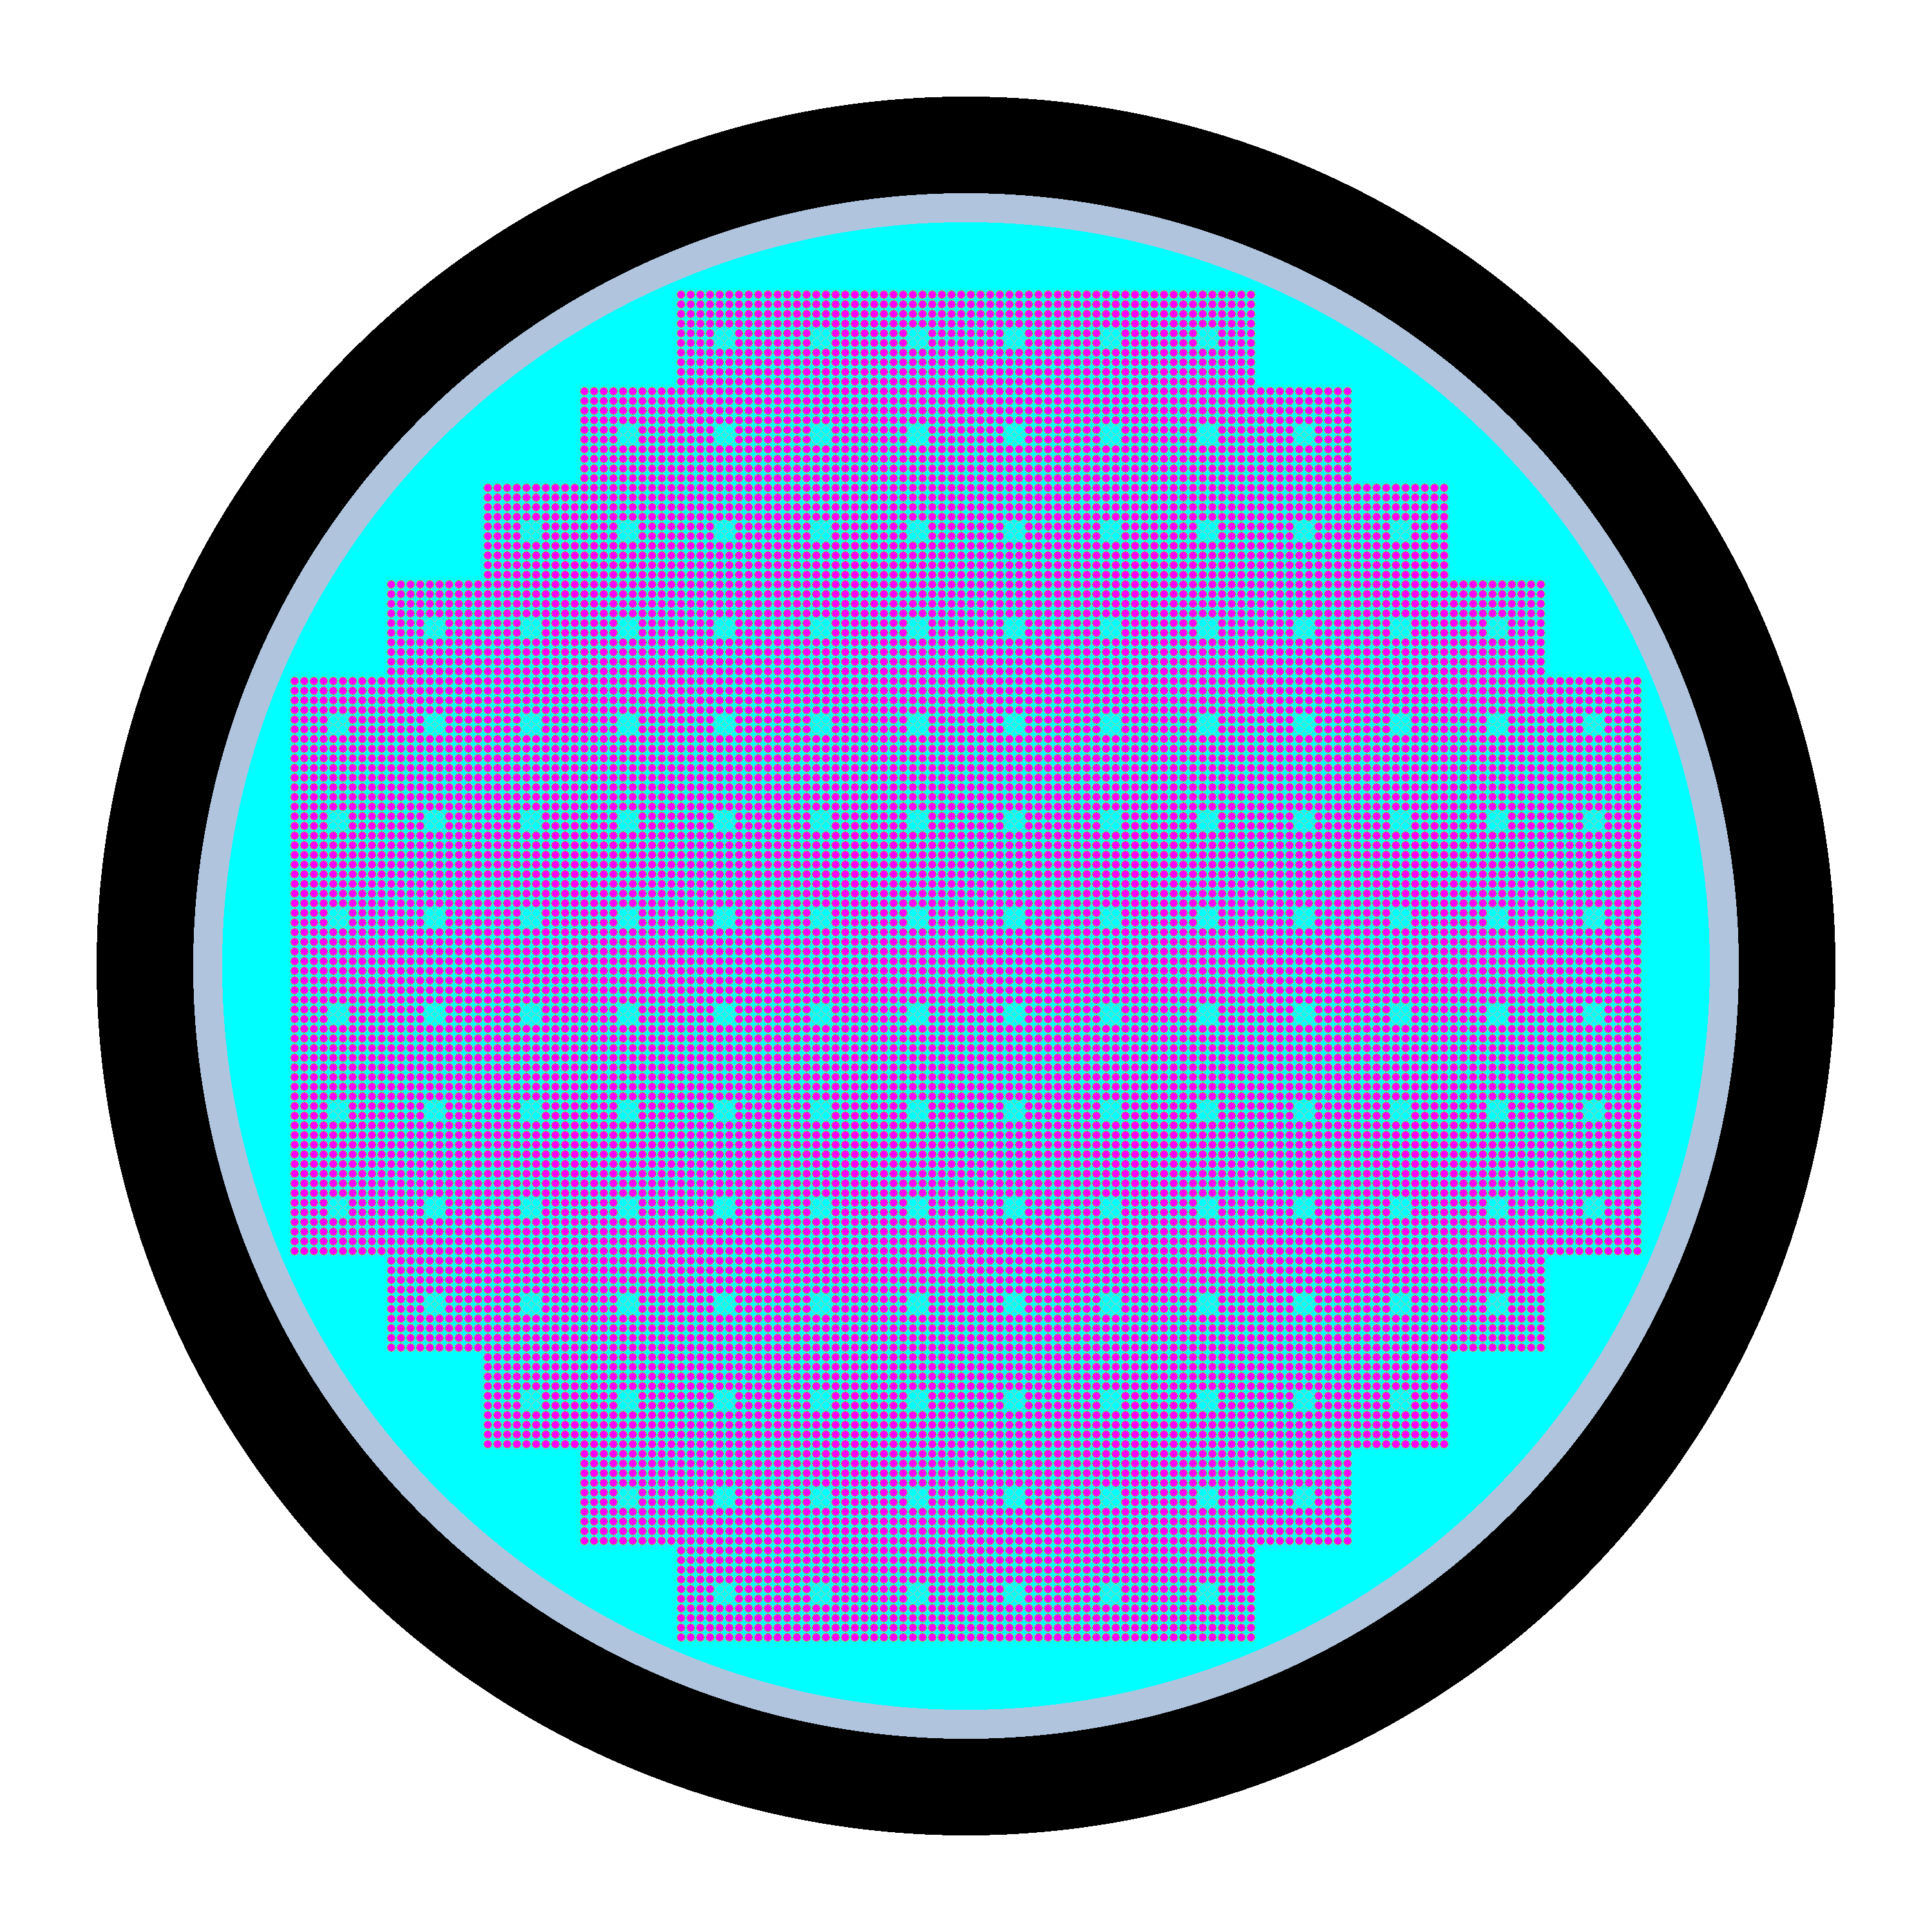

In [15]:
openmc.plot_inline(p1)

In [16]:
#openmc.plot_inline(p2)

In [17]:
#openmc.plot_inline(p3)

Running depletion chain:

In [18]:
'''
print("Running depletion...")
op = openmc.deplete.Operator(geometry, settings, chain_file)

# Perform simulation using the cf4 algorithm
openmc.deplete.CF4Integrator(op, timesteps, power).integrate()
'''

'\nprint("Running depletion...")\nop = openmc.deplete.Operator(geometry, settings, chain_file)\n\n# Perform simulation using the cf4 algorithm\nopenmc.deplete.CF4Integrator(op, timesteps, power).integrate()\n'

In [19]:
#openmc.run()

Statepoint tally information:

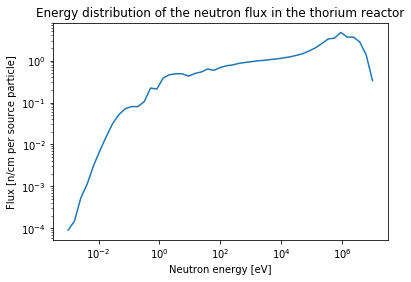

"plt.loglog(bins,gamma_flux_energy.mean[:,0,0])\nplt.xlabel('Neutron energy [eV]')\nplt.ylabel('Flux [n/cm per source particle]')\nplt.title('Energy distribution of the gamma flux in the thorium reactor')\n#plt.savefig('gammafluxdistthorium.png',dpi=500)\nplt.show()"

In [20]:
sp = openmc.StatePoint('statepoint.100.h5')
'''sp_tally = sp.get_tally(scores=['flux','fission','nu-fission'])


flux = sp_tally.get_slice(scores=['flux'])
neutron_flux = flux.get_slice(filters = [openmc.ParticleFilter], 
                              filter_bins=[(('neutron'),)], squeeze = True)


fission = sp_tally.get_slice(scores=['fission'])
neutron_fission = fission.get_slice(filters = [openmc.ParticleFilter],
                                   filter_bins = [(('neutron'),)], squeeze = True)

nu_fission = sp_tally.get_slice(scores=['nu-fission'])

neutron_flux.std_dev.shape=(200,200)
neutron_flux.mean.shape=(200,200)

neutron_fission.std_dev.shape=(200,200)
neutron_fission.mean.shape=(200,200)


plt.imshow(neutron_flux.mean)
plt.colorbar()
plt.xlabel('x-direction')
plt.ylabel('y-direction')
#plt.savefig('fluxdistxy.png',dpi=500)
plt.show()'''


en_tally = sp.get_tally(name='energy flux tally')
neutron_flux_energy = en_tally.get_slice(scores=['flux'],
                                 filters = [openmc.ParticleFilter],
                                filter_bins=[(('neutron'),)], squeeze = True)

'''
#Remember to turn on photon transport before using photon filter:
gamma_flux_energy = en_tally.get_slice(scores=['flux'],
                                      filters = [openmc.ParticleFilter],
                                       filter_bins=[(('photon'),)], 
                                       squeeze = True)
'''


bins = np.logspace(-3,7,49)
plt.loglog(bins,neutron_flux_energy.mean[:,0,0])
plt.xlabel('Neutron energy [eV]')
plt.ylabel('Flux [n/cm per source particle]')
plt.title('Energy distribution of the neutron flux in the thorium reactor')
#plt.savefig('neutronfluxdistthorium.png',dpi=500)
plt.show()


'''plt.loglog(bins,gamma_flux_energy.mean[:,0,0])
plt.xlabel('Neutron energy [eV]')
plt.ylabel('Flux [n/cm per source particle]')
plt.title('Energy distribution of the gamma flux in the thorium reactor')
#plt.savefig('gammafluxdistthorium.png',dpi=500)
plt.show()'''

Calculate the thermal utilization factor:


In [21]:
sp = openmc.StatePoint('statepoint.100.h5')

utilization_factor_tally = sp.get_tally(name='Utilization factor')
therm_abs_rate = sp.get_tally(name='therm. abs. rate')

thermal_utilization = utilization_factor_tally / therm_abs_rate
thermal_utilization.get_pandas_dataframe()

,energy low [eV],energy high [eV],universe,nuclide,score,mean,std. dev.
0,0.0,0.05,6,total,(absorption / absorption),0.649849,0.009564


Spatial distribution of the sites:

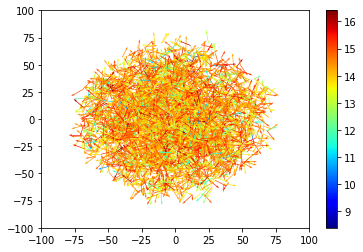

In [22]:
plt.quiver(sp.source['r']['x'], sp.source['r']['y'],
           sp.source['u']['x'], sp.source['u']['y'],
           np.log(sp.source['E']), cmap='jet', scale=20.0)
plt.colorbar()
plt.xlim((-100,100))
plt.ylim((-100,100))
plt.show()

Tally data processing:

In [23]:
tally_info = sp.get_tally()

# Get a pandas dataframe for the mesh tally data
df = tally_info.get_pandas_dataframe(nuclides=False)

# Set the Pandas float display settings
pd.options.display.float_format = '{:.2e}'.format

# Print the first twenty rows in the dataframe
#df.head(20)

In [24]:
###############################################################################
#                    Read depletion calculation results
###############################################################################
print("Before results list")

# Open results file
results = openmc.deplete.ResultsList.from_hdf5("/Users/Julian/Desktop/FYS4580/FYS4580/OpenMC_Project/depletion_results.h5")

# Obtain K_eff as a function of time
time, keff = results.get_eigenvalue()


# Obtain Pu concentration as a function of time
_time, n_Pu239 = results.get_atoms('11', 'Pu239')
_time, n_Pu240 = results.get_atoms('11', 'Pu240')

# Obtain U concentration as a function of time
time, n_U232 = results.get_atoms('11', 'U232')
time, n_U233 = results.get_atoms('11', 'U233')
time, n_U235 = results.get_atoms('11', 'U235')
time, n_U238 = results.get_atoms('11', 'U238')
# Obtain Xe135 absorption as a function of time
time, Xe_gam = results.get_reaction_rate('11', 'Xe135', '(n,gamma)')
time, Sm_gam = results.get_reaction_rate('11', 'Sm149', '(n,gamma)')
time, n_I135 = results.get_atoms('11', 'I135')
time, n_Cs135 = results.get_atoms('11', 'Cs135')
time, n_Gd157 = results.get_atoms('11', 'Gd157')
time, n_Gd156 = results.get_atoms('11', 'Gd156')

time, n_U234 = results.get_atoms('11', 'U234')

time, n_Th232 = results.get_atoms('11', 'Th232')
time, n_Th233 = results.get_atoms('11', 'Th233')
time, n_Pa233 = results.get_atoms('11', 'Pa233')
time, n_U233 = results.get_atoms('11', 'U233')

time, n_Xe135 = results.get_atoms('11', 'Xe135')
time, n_Sm149 = results.get_atoms('11', 'Sm149')


Before results list


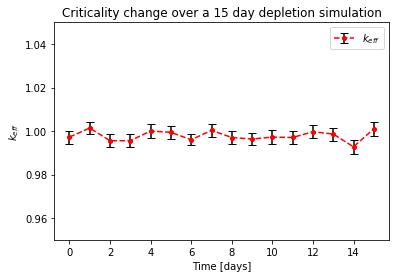

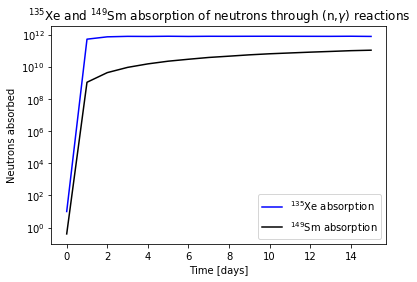

<Figure size 432x288 with 0 Axes>

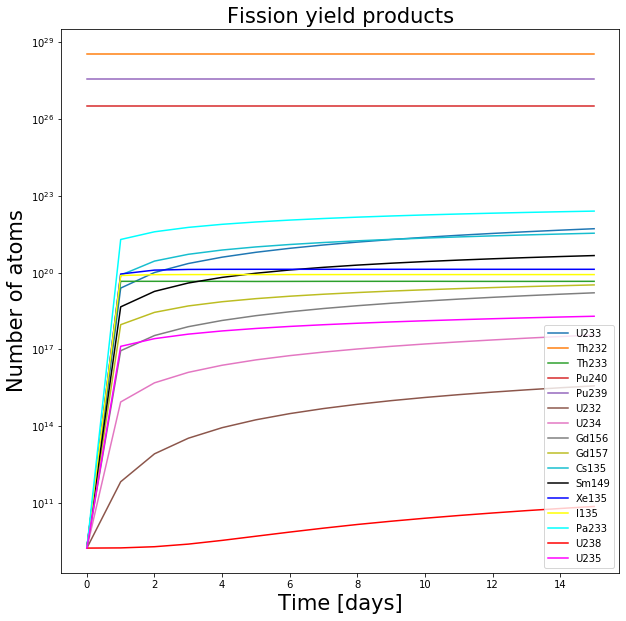

In [26]:
plt.figure()
plt.errorbar(time/(24*60*60), keff[:,0],yerr=keff[:,1], color='red',
             ls='--', marker='o',markersize=4,capsize=4, ecolor='black',
             label=r"$k_{eff}$")
plt.xlabel("Time [days]")
plt.ylabel(r"$k_{eff}$")
plt.title('Criticality change over a 15 day depletion simulation')
plt.ylim(0.95,1.05)
plt.legend()
#plt.savefig('keff-depletion.png',dpi=500)
plt.show()

plt.figure()
plt.semilogy(time/(24*60*60), Xe_gam, label=r'${}^{135}$Xe absorption',color='blue')
plt.semilogy(time/(24*60*60), Sm_gam, label=r'${}^{149}$Sm absorption',color='black')
plt.xlabel("Time [days]")
plt.ylabel('Neutrons absorbed')
plt.title(r'${}^{135}$Xe and ${}^{149}$Sm absorption of neutrons through (n,$\gamma$) reactions')
plt.legend()
#plt.savefig('xe135sm149absorption',dpi=500)
plt.show()



plt.figure()
plt.figure(figsize=(10,10))
plt.semilogy(time/(24*60*60), n_U233, label="U233")
plt.semilogy(time/(24*60*60), n_Th232, label="Th232")
plt.semilogy(time/(24*60*60), n_Th233, label="Th233")
plt.semilogy(time/(24*60*60), n_Pu240, label="Pu240")
plt.semilogy(time/(24*60*60), n_Pu239, label="Pu239")
plt.semilogy(time/(24*60*60), n_U232, label="U232")
plt.semilogy(time/(24*60*60), n_U234, label="U234")
plt.semilogy(time/(24*60*60), n_Gd156, label="Gd156")
plt.semilogy(time/(24*60*60), n_Gd157, label="Gd157")
plt.semilogy(time/(24*60*60), n_Cs135, label="Cs135")
plt.semilogy(time/(24*60*60), n_Sm149, label="Sm149", color="black")
plt.semilogy(time/(24*60*60), n_Xe135, label="Xe135", color = "blue")
plt.semilogy(time/(24*60*60), n_I135, label="I135", color = "yellow")
plt.semilogy(time/(24*60*60), n_Pa233, label="Pa233", color = "cyan")
plt.semilogy(time/(24*60*60), n_U238, label="U238", color="red")
plt.semilogy(time/(24*60*60), n_U235, label="U235", color="magenta")

plt.legend()
plt.title('Fission yield products',size=21)
plt.xlabel("Time [days]", size=21)
plt.ylabel("Number of atoms", size=21)
#plt.savefig('fissionyieldproducts.png',dpi=500)
plt.show()